## loading dataset

In [10]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d subhajournal/phishingemails
!unzip phishingemails.zip

cp: kaggle.json: No such file or directory
Dataset URL: https://www.kaggle.com/datasets/subhajournal/phishingemails
License(s): GNU Lesser General Public License 3.0
phishingemails.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  phishingemails.zip
replace Phishing_Email.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [16]:
import pandas as pd

df = pd.read_csv('Phishing_Email.csv')
df

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email
...,...,...,...
18645,18646,date a lonely housewife always wanted to date ...,Phishing Email
18646,18647,request submitted : access request for anita ....,Safe Email
18647,18648,"re : important - prc mtg hi dorn & john , as y...",Safe Email
18648,18649,press clippings - letter on californian utilit...,Safe Email


## Prepocessing

clean up the skips

In [20]:
df.isnull().sum()

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

In [22]:
df = df.drop(["Unnamed: 0"],axis=1).dropna(axis=0).drop_duplicates()
print(df.shape)
df.head()

(17538, 2)


,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email


translate the values into the target variable 

In [25]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df["Email Type"] = le.fit_transform(df["Email Type"])
df

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",1
1,the other side of * galicismos * * galicismo *...,1
2,re : equistar deal tickets are you still avail...,1
3,\nHello I am your hot lil horny toy.\n I am...,0
4,software at incredibly low prices ( 86 % lower...,0
...,...,...
18644,\nRick Moen a Ã©crit:> > I'm confused. I thou...,1
18645,date a lonely housewife always wanted to date ...,0
18646,request submitted : access request for anita ....,1
18647,"re : important - prc mtg hi dorn & john , as y...",1


### Vectorizing

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np

tfidf = TfidfVectorizer(stop_words="english",max_features=10000)
X = tfidf.fit_transform(df["Email Text"]).toarray()
y = np.array(df['Email Type'])

### Split into training and test sample

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

## Application of different models

### Metrics

In [35]:
from sklearn.metrics import (accuracy_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

def show_metrics(name, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)*100
    f1 = f1_score(y_test, y_pred)*100
    precision = precision_score(y_test, y_pred)*100
    print(f'{name}: ')
    print(f"Accuracy: {accuracy:.2f} %")
    print(f"F1 score: {f1:.2f} %")
    print(f"Precision: {precision:.2f} %\n")

    conf_m = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(conf_m,display_labels=['pishing_mail','safe_mail']).plot()
    plt.title("ConfusionMatrix")
    plt.show()

    return name, accuracy, f1, precision

In [37]:
results = []

### LogisticRegression

LogisticRegression: 
Accuracy: 98.55 %
F1 score: 98.81 %
Precision: 99.21 %



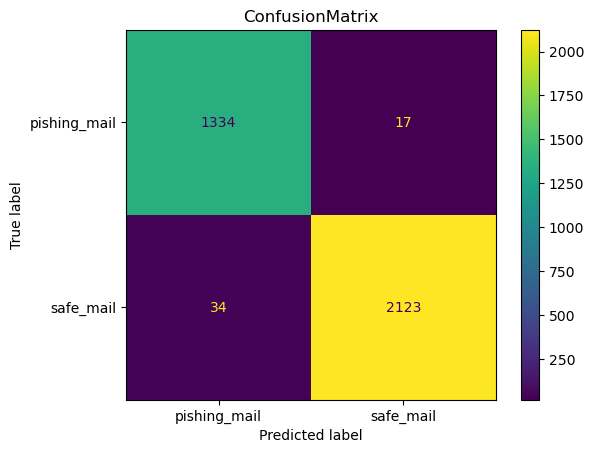

In [40]:
from sklearn.linear_model import LogisticRegression


lg = LogisticRegression(penalty=None)
lg.fit(X_train, y_train)

y_pred = lg.predict(X_test)

results.append(show_metrics('LogisticRegression', y_test, y_pred))

### RandomForestClassifier

RandomForestClassifier: 
Accuracy: 98.06 %
F1 score: 98.41 %
Precision: 99.01 %



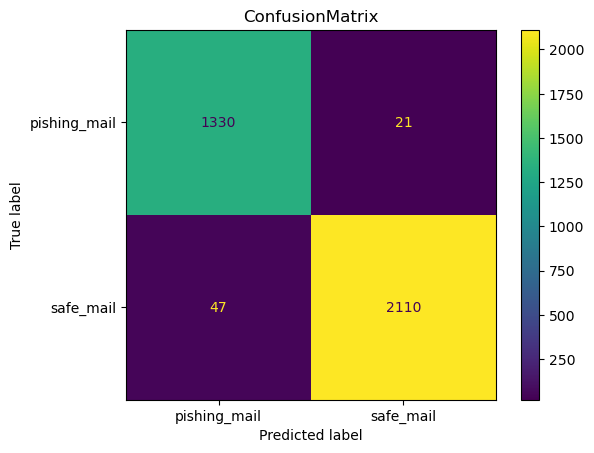

In [42]:
from sklearn.ensemble import RandomForestClassifier

rnf_clf = RandomForestClassifier(n_estimators=120, random_state=0)
rnf_clf.fit(X_train, y_train)

y_pred = rnf_clf.predict(X_test)

results.append(show_metrics('RandomForestClassifier', y_test, y_pred))

### SGDClassifier

SGDClassifier: 
Accuracy: 98.57 %
F1 score: 98.84 %
Precision: 98.84 %



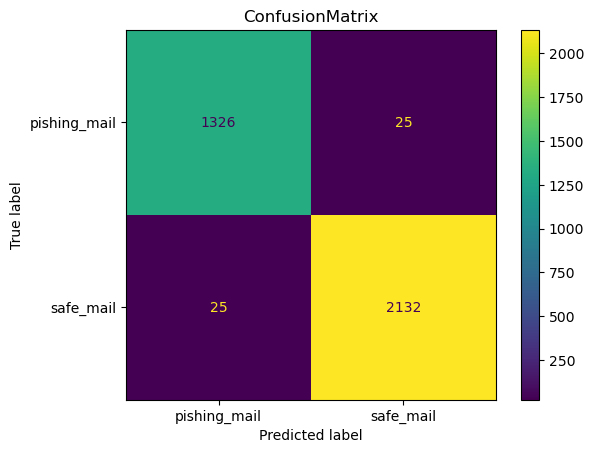

In [44]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(n_jobs=20, random_state=0)
sgd_clf.fit(X_train, y_train)

y_pred = sgd_clf.predict(X_test)

results.append(show_metrics('SGDClassifier', y_test, y_pred))

### XGBClassifier

XGBClassifier: 
Accuracy: 97.92 %
F1 score: 98.30 %
Precision: 98.97 %



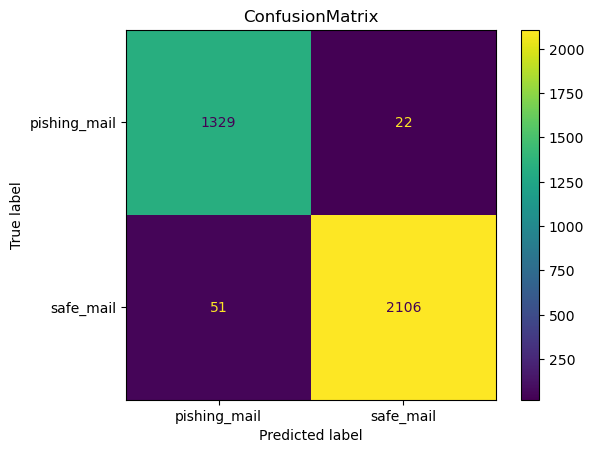

In [46]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, max_depth=10)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

results.append(show_metrics('XGBClassifier', y_test, y_pred))

### Comparison of model quality metrics

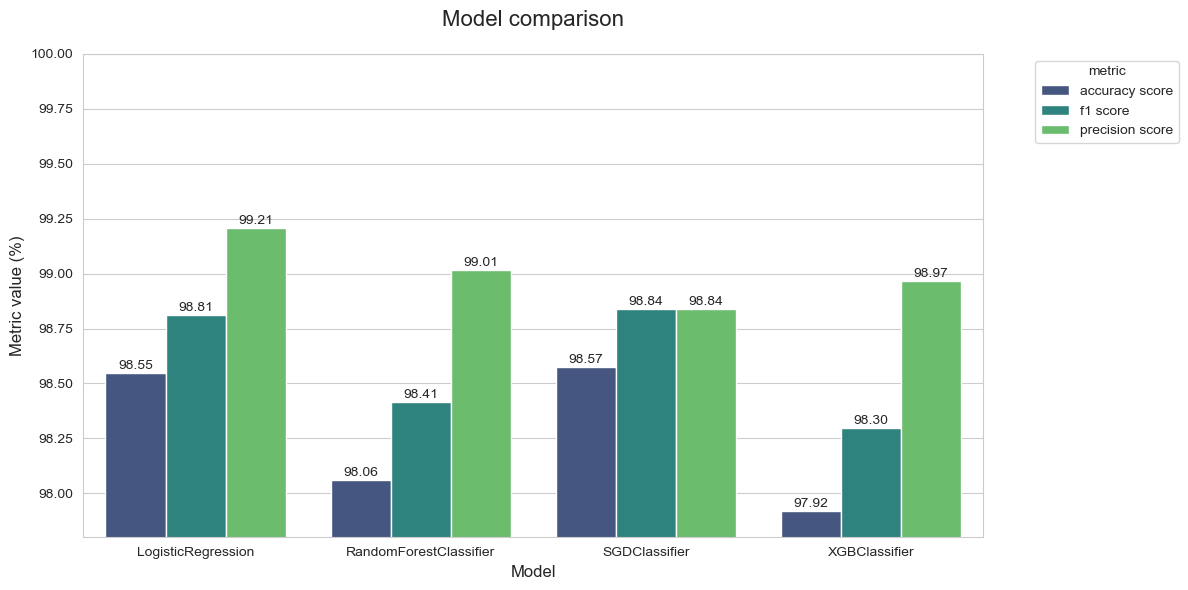

In [49]:
import seaborn as sns

metrics_df = pd.DataFrame(results, columns=['name', 'accuracy score', 'f1 score', 'precision score'])

df_melted = metrics_df.melt(id_vars='name', var_name='metric', value_name='score')

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x='name', y='score', hue='metric', data=df_melted, palette='viridis')

plt.title('Model comparison', fontsize=16, pad=20)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Metric value (%)', fontsize=12)
plt.ylim(97.8, 100)  # Увеличиваем контраст различий
ax.legend(title='metric', bbox_to_anchor=(1.05, 1), loc='upper left')

# Добавляем значения на столбцы
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

For phishing email classification, precision is critical to minimize false positives (legitimate emails flagged as phishing). LogisticRegression is the best choice with 99.21% precision, outperforming other models.